In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
line_img = np.array(Image.open("train/line.png")) / 255.0
white_img = np.array(Image.open("train/white.jpg")) / 255.0

In [3]:
images = np.stack([white_img] * 20 + [line_img] * 20)

In [4]:
labels = np.array([0] * 20 + [1] * 20)

In [5]:
images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # (100, 3, 1284, 310)
labels = torch.tensor(labels, dtype=torch.long)

In [6]:
print(f"  Shape: {images.shape}")

  Shape: torch.Size([40, 3, 310, 1284])


In [7]:
dataset = TensorDataset(images, labels)
num_subset_samples = 40
subset_indices = torch.randperm(len(dataset))[:num_subset_samples].tolist()
subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=1, shuffle=True)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.fc = nn.Linear(32 * 19 * 80, 2)  # Adjust based on output size

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [9]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
model.train()
for epoch in range(5):
    for batch_images, batch_labels in dataloader:  # Use distinct names to avoid overwrite
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.08787452429533005
Epoch 2, Loss: 0.011431078426539898
Epoch 3, Loss: 0.002056628232821822
Epoch 4, Loss: 0.0010946955299004912
Epoch 5, Loss: 0.000513064325787127


In [11]:
print(f"Images shape: {images.shape}")

Images shape: torch.Size([40, 3, 310, 1284])


Image 1 (Index 10): True Label: white_img (0), Predicted: white_img (0)
Image 2 (Index 38): True Label: line_img (1), Predicted: line_img (1)
All Predictions: [0, 1] (['white_img', 'line_img'])
All True Labels: [0, 1] (['white_img', 'line_img'])
Accuracy: 100.00%


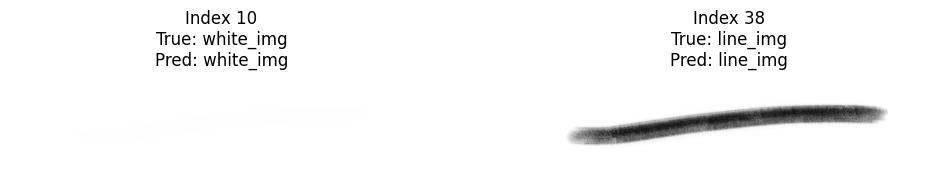

In [16]:
model.eval()
with torch.no_grad():
    # Randomly select 2 indices
    num_samples = 2
    random_indices = torch.randperm(len(dataset))[:num_samples]  # e.g., [5, 25]
    eval_images = images[random_indices]  # Shape: [2, 3, 310, 1284]
    eval_labels = labels[random_indices]  # Shape: [2]
    outputs = model(eval_images)  # Shape: [2, 2]
    predictions = torch.argmax(outputs, dim=1)  # Shape: [2]
    
    # Define class names
    class_names = {0: 'white_img', 1: 'line_img'}
    
    # Print true labels and predictions for each image
    for i, idx in enumerate(random_indices):
        true_label = eval_labels[i].item()
        pred_label = predictions[i].item()
        print(f'Image {i+1} (Index {idx.item()}): True Label: {class_names[true_label]} ({true_label}), Predicted: {class_names[pred_label]} ({pred_label})')
    
    # Print overall predictions and true labels
    print(f'All Predictions: {predictions.tolist()} ({[class_names[p.item()] for p in predictions]})')
    print(f'All True Labels: {eval_labels.tolist()} ({[class_names[l.item()] for l in eval_labels]})')
    
    # Calculate and print accuracy
    accuracy = (predictions == eval_labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

    # Display the selected images
    plt.figure(figsize=(12, 5))  # Adjust figure size for two images
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)
        img = eval_images[i].permute(1, 2, 0).numpy()  # Convert [3, 310, 1284] to [310, 1284, 3]
        plt.imshow(img)  # Display RGB image (normalized to [0, 1])
        plt.title(f'Index {idx.item()}\nTrue: {class_names[eval_labels[i].item()]}\nPred: {class_names[predictions[i].item()]}')
        plt.axis('off')
    plt.show()